<a href="https://colab.research.google.com/github/h0806449f/PyTorch/blob/main/DB_05_going_modular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **=== 0. 簡介 ===**
1. Run from command line
2. Final target structure
3. Will create multiple python file for different functions and purpose and achieve target structure


## 0.1 Example for run python from command line




In [1]:
# python train.py --model MODEL_NAME --batch_size BATCH_SIZE --lr LEARNING_RATE --num_epochs NUM_EPOCHS

In [2]:
# python train.py --model model_1 --batch_size 100 --lr 0.001 --num_epochs 50

## 0.2 Final target structure

In [3]:
# going_modular/
# ├── going_modular/
# │   ├── data_setup.py
# │   ├── engine.py
# │   ├── model_builder.py
# │   ├── train.py
# │   └── utils.py
# ├── models/
# │   ├── 05_going_modular_cell_mode_tinyvgg_model.pth
# │   └── 05_going_modular_script_mode_tinyvgg_model.pth
# └── data/
#     └── pizza_steak_sushi/
#         ├── train/
#         │   ├── pizza/
#         │   │   ├── image01.jpeg
#         │   │   └── ...
#         │   ├── steak/
#         │   └── sushi/
#         └── test/
#             ├── pizza/
#             ├── steak/
#             └── sushi/

# **=== 1. Get data (download data) ===**
Download the data and set into specific data dtructure

In [1]:
# Import
import requests             # HTTP request
import zipfile              # zip & unzip
import os                   #
from pathlib import Path    #

# 設置 data path 變數
data_folder = Path("Data/")
image_folder = data_folder / "Pizze_Steak_Sushi"

# 判斷是否已有資料夾 -> 無: 創造 / 有: 可重複接受
if image_folder.is_dir():
    print(f"{image_folder} 資料夾已存在")
else:
    print(f"{image_folder} 未發現資料夾, 創造 ...")
    image_folder.mkdir(parents = True, exist_ok = True) # 無上層資料夾, 也會創造 image_folder 資料夾 / 已有資料夾, 不返回error

# 下載
with open(image_folder / "pizza_steak_sushi.zip", "wb") as f: # 名稱需一致 (pizza_steak_sushi.zip)
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("downloading ...")
    f.write(request.content)

# 解壓縮
with zipfile.ZipFile (image_folder / "pizza_steak_sushi.zip", "r") as zip_f:
    print("unziping ...")
    zip_f.extractall(image_folder)

# 移除 壓縮檔
os.remove(image_folder / "pizza_steak_sushi.zip")

Data/Pizze_Steak_Sushi 未發現資料夾, 創造 ...
downloading ...
unziping ...


# **=== 2. Data_setup.py ===**
1. Wrtie -> functions in Data_setup.py
2. Test
2. Import

## 2.1 Func: create_dataloader() in **Data_setup.py**

In [2]:
# writefile 將以下內容, 寫入指定檔案中 (須去除前置# writefile 才會正常運作)
# %%writefile going_modular/Data_setup.py
"""將創造 Pytorch DataLoader 用於影像分類"""

# Import
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Create function - create_dataloader()
# 預先設置參數的資料型態: 日後易維護, IDE可能偵錯

NUM_WORKERS = os.cpu_count()

def create_dataloader(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=None):
    # 解說
    """
    創造:
        train_dataloader, test_dataloader

    變數:
        train_dir: 訓練資料路徑
        test_dir: 測試資料路徑
        transform: Pytorch torchvision transforms
        batch_size: 每批次資料數量
        num_workers: workers per DataLoader

    返還:
        tuple(train_dataloader, test_dataloader, class_names)
        class_names 為list 包含訓練資料的 classes

    範例:
        train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=path/to/train_dir,
                                                                            test_dir=path/to/test_dir,
                                                                            transform=some_transform,
                                                                            batch_size=32,
                                                                            num_workers=4)
    """

    # NUM_WORKERS
    if num_workers is None:
        num_workers = NUM_WORKERS

    # ImageFolder -> datasset
    train_dataset = datasets.ImageFolder(train_dir, transform=transform)
    test_dataset = datasets.ImageFolder(test_dir, transform=transform)

    # Get train_dataset class
    class_name = train_dataset.classes

    # Dataset -> dataloader
    train_dataloader = DataLoader(train_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=num_workers,
                                  pin_memory=True) # pin_memory 使用GPU時 可加快處理速度

    test_dataloader = DataLoader(test_dataset,
                                 batch_size=batch_size,
                                 shuffle=False,
                                 num_workers=num_workers,
                                 pin_memory=True)

    return train_dataloader, test_dataloader, class_name

Writing going_modular/Data_setup.py


## 2.2 Test

In [34]:
import torch
from torchvision import transforms
from torchvision.transforms import ToTensor

train_path = "/content/Data/Pizze_Steak_Sushi/train"
test_path = "/content/Data/Pizze_Steak_Sushi/test"

transform = transforms.Compose([
    ToTensor()
])

create_dataloader(train_dir=train_path,
                  test_dir=test_path,
                  transform=transform,
                  batch_size=100)

(<torch.utils.data.dataloader.DataLoader at 0x7f1708dc70d0>,
 ['pizza', 'steak', 'sushi'])

## 2.3 Import

In [41]:
from going_modular import Data_setup

train_dataloader, test_dataloader, class_names = create_dataloader(train_dir=train_path,
                                                                   test_dir=test_path,
                                                                   transform=transform,
                                                                   batch_size=100)

# **=== 3. Models.py ===**
1. Write -> functions in Model.py
2. Test
3. Import

## 3.1 Multiple models in **Models.py**

In [3]:
# writefile 將以下內容, 寫入指定檔案中 (須去除前置# writefile 才會正常運作)
# %%writefile going_modular/Models.py
"""將創造 tinyVGG 模型"""

# Import
import torch
from torch import nn

# Class
class TinyVGG(nn.Module):
    """
    原網址: https://poloclub.github.io/cnn-explainer/
    原網址輸入圖片皆為 64*64*3

    Args:
        input_shape: number of input channels
        hidden_units: number of hidden units
        output_shape: number of output channels
    """

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int)->None:
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=1))

        self.block2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(38440, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, output_shape))

    def forward(self, x: torch.Tensor):
        x = self.block1(x)
        x = self.block2(x)
        x = self.classifier(x)
        return x

Writing going_modular/Models.py


## 3.2 Test

In [80]:
device = "cuda" if torch.cuda.is_available() else "cpu"


model_1 = TinyVGG(64,10,len(class_names)).to(device)
print(model_1)

TinyVGG(
  (block1): Sequential(
    (0): Conv2d(64, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=38440, out_features=1024, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=1024, out_features=128, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.3, inplace=False)
    (7): Linear(in_features=128, out_features=3, bias=True)
  )
)


## 3.3 Import

In [87]:
# Import
from going_modular import Models
import torch

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Manual_seed
torch.manual_seed(42)

# 指定
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=3).to(device)
print(model_1)

TinyVGG(
  (block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=38440, out_features=1024, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=1024, out_features=128, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.3, inplace=False)
    (7): Linear(in_features=128, out_features=3, bias=True)
  )
)


# **=== 4. Engine.py ===**
1. Write -> 3 functions in Engine.py
2. Functions: train, test, train_test_loop
3. Test
4. Import

## 4.1 Func: train, test, train_test_loop in **Engine.py**

In [4]:
# %%writefile going_modular/Engine.py
"""將創造 train(), test(), training_loop()"""

# Import
import torch
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

# Train
def train(model: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          device: torch.device) -> Tuple[float, float]:
    """
    Train 1 epoch

    Args:
        model: 欲訓練模型
        dataloader: 該模型的 dataloader
        loss_fn: 計算損失函數
        optimizer: 優化損失函數
        device: 運作在何種裝置上

    Returns:
        Tuple (train_loss, train_accuracy)
    """
    model.to(device)
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X_train, y_train) in enumerate(dataloader):
        # To device
        X_train, y_train = X_train.to(device), y_train.to(device)

        # Forward pass
        train_preds = model(X_train)

        # Calculate & Accumulate the loss
        loss = loss_fn(train_preds, y_train)
        train_loss = train_loss + loss.item()

        # Optimizer zero grad
        optimizer.zero_grad()

        # Loss back ward
        loss.backward()

        # Optimizer step
        optimizer.step()

        # Calculate the accuracy (y_preds is logits -> probs that sum=1 -> argmax for label)
        train_preds_class = torch.argmax(torch.softmax(train_preds, dim=1), dim=1)
        train_acc = train_acc + (train_preds_class == y_train).sum().item() / len(train_preds)

    # Calculate average loss and accuracy for each batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc


# Test
def test(model: torch.nn.Module,
         dataloader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         device: torch.device) -> Tuple[float, float]:
    """
    Test 1 epoch

    Args:
        model: 欲訓練模型
        dataloader: 該模型的 dataloader
        loss_fn: 計算損失函數
        device: 運作在何種裝置上

    Returns:
        Tuple (tesr_loss, test_accuracy)
    """
    model.to(device)
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X_test, y_test) in enumerate(dataloader):
            # To device
            X_test, y_test = X_test.to(device), y_test.to(device)

            # Forward pass
            test_preds = model(X_test)

            # Calculate & accumulate the loss
            loss = loss_fn(test_preds, y_test)
            test_loss = test_loss + loss

            # Calculate & accumulate the accuracy
            test_preds_labels = torch.argmax(torch.softmax(test_preds, dim=1), dim=1)
            test_acc = test_acc + (test_preds_labels == y_test).sum().item() / len(test_preds)

        test_loss = test_loss / len(dataloader)
        test_acc = test_acc / len(dataloader)

        return test_loss, test_acc


# Train_test_loop
def train_test_loop(model: torch.nn.Module,
                    train_dataloader: torch.utils.data.DataLoader,
                    test_dataloader: torch.utils.data.DataLoader,
                    loss_fn: torch.nn.Module,
                    optimizer: torch.optim.Optimizer,
                    epochs: int,
                    device: torch.device) -> Dict[str, List]:
    """
    Train & test for specific epochs

    Args:
        model: 欲訓練模型
        dataloader: 該模型的 dataloader
        loss_fn: 計算損失函數
        optimizer: 優化損失函數
        device: 運作在何種裝置上
        epochs: 欲訓練次數

    Returns:
        Dict{train_loss: [ ... ],
             train_acc: [ ... ],
             test_loss: [ ... ],
             test_acc: [ ... ]}
    """
    # 空字典, 儲存結果
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    for epoch in tqdm(range(epochs)):
        # Train
        train_loss, train_acc = train(model=model,
                                      dataloader=train_dataloader,
                                      loss_fn=loss_fn,
                                      optimizer=optimizer,
                                      device=device)

        # Test
        test_loss, test_acc = test(model=model,
                                   dataloader=test_dataloader,
                                   loss_fn=loss_fn,
                                   device=device)

        # Print process
        print(f"Epochs: {epoch}\n"
              f"Train loss: {train_loss} | Train acc: {train_acc}\n"
              f"Test loss: {test_loss} | Test acc: {test_acc}")

        # Update result Dict
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

Writing going_modular/Engine.py


## 4.2 Test

In [114]:
# Data path
train_path = "/content/Data/Pizze_Steak_Sushi/train"
test_path = "/content/Data/Pizze_Steak_Sushi/test"

# Transform
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Dataloader
BATCH_SIZE = 1
train_dataloader, test_dataloader, class_names = create_dataloader(train_dir=train_path,
                                                                   test_dir=test_path,
                                                                   transform=transform,
                                                                   batch_size=BATCH_SIZE)

#
device = "cuda" if torch.cuda.is_available() else "cpu"
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(),
                             lr=0.001)

results_1 = train_test_loop(model=model_1,
                            train_dataloader = train_dataloader,
                            test_dataloader = test_dataloader,
                            loss_fn = loss_fn,
                            optimizer = optimizer,
                            epochs=5,
                            device = device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epochs: 0
Train loss: 1.0614273049960805 | Train acc: 0.47555555555555556
Test loss: 1.0874457359313965 | Test acc: 0.38666666666666666
Epochs: 1
Train loss: 0.9243123758469503 | Train acc: 0.5688888888888889
Test loss: 1.0457584857940674 | Test acc: 0.4666666666666667
Epochs: 2
Train loss: 0.9977163959723798 | Train acc: 0.5555555555555556
Test loss: 1.0302966833114624 | Test acc: 0.4
Epochs: 3
Train loss: 0.931575952624755 | Train acc: 0.6222222222222222
Test loss: 1.0164368152618408 | Test acc: 0.48
Epochs: 4
Train loss: 0.7529415562789573 | Train acc: 0.6622222222222223
Test loss: 1.197981595993042 | Test acc: 0.5066666666666667


## 4.3 Import

In [122]:
from going_modular import Engine
import inspect

functions = inspect.getmembers(Engine, inspect.isfunction)
for name, info in functions:
    print(f"Function name: {name} -> info: {info}\n")

Function name: test -> info: <function test at 0x7f16400ed510>

Function name: train -> info: <function train at 0x7f16400ee7a0>

Function name: train_test_loop -> info: <function train_test_loop at 0x7f1631f1e3b0>



# **=== 5. Utils.py ===**
1. Func: save_model() in **Utils.py**
2. Test
4. Import

## 5.1 Func: save_model() in **Utils.py**

In [5]:
# %%writefile going_modular/Utils.py
"""目前有: 儲存功能"""
import torch
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
    """
    儲存模型至指定路徑資料夾

    Args:
        model: 模型名稱,
        target_dir: 模型儲存路徑,
        model_name: 儲存後模型名稱, ex. model.pt / model.pth

    Ex:
        save_model(model = model_1,
                   target_dir = Data/Models,
                   model_name = "Model_1_TinyVGG.pt")
    """
    # Create target dir
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents = True, exist_ok = True)

    # 判斷模型是否以特定字串結尾, 否則返回指定訊息
    # Create model saved path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should ends with '.pt' or '.pth'."
    model_saved_path = target_dir_path / model_name

    # 儲存模型
    print(f"[INFO] Saving model to {model_saved_path}")
    torch.save(obj = model.state_dict(),
               f = model_saved_path)

Writing going_modular/Utils.py


## 5.2 Test

## 5.3 import

In [8]:
from going_modular import Utils
import inspect

functions = inspect.getmembers(Utils, inspect.isfunction)

for name, info in functions:
    print(f"Function name: {name}")
    print(f"Function info: {info}")

Function name: save_model
Function info: <function save_model at 0x7fae271b5480>


# **=== 6. Train.py ===**
1. 執行檔, 整合以上所有 functions
2. 執行檔名稱通常為 train.py

In [16]:
# %%writefile going_modular/Train.py
"""Train a Pytorch image classification model"""
# Import
import os
from going_modular import Data_setup, Engine, Models, Utils
import torch
import torchvision
from torchvision import transforms

# Hyperparameters
NUM_EPOCHS = 5
BATCH_SIZE = 32
HIDDEN_UNITS = 10
LEARNING_RATE = 0.001

# Set train, test dir
train_dir = "/content/Data/Pizze_Steak_Sushi/train"
test_dir = "/content/Data/Pizze_Steak_Sushi/test"

# Set transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Set dataloader
# By calling func: create_dataloader() from Data_setup.py
train_dataloader, test_dataloader, class_names = Data_setup.create_dataloader(train_dir = train_dir,
                                                                              test_dir = test_dir,
                                                                              transform = transform,
                                                                              batch_size = BATCH_SIZE)

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set model
# By calling Models.py
model_2 = Models.TinyVGG(input_shape = 3,
                         hidden_units = HIDDEN_UNITS,
                         output_shape = len(class_names))

# Set loss_fn & optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(),
                             lr = LEARNING_RATE)

# !!! Start train !!!
result_2 = Engine.train_test_loop(model = model_2,
                                  train_dataloader = train_dataloader,
                                  test_dataloader = test_dataloader,
                                  loss_fn = loss_fn,
                                  optimizer = optimizer,
                                  device = device,
                                  epochs = NUM_EPOCHS)

# Save model_2
# By calling save_model() from Utils.py
Utils.save_model(model = model_2,
                 target_dir = "/content/going_modular",
                 model_name = "Model_2_for_temptest.pt")

  0%|          | 0/5 [00:00<?, ?it/s]

Epochs: 0
Train loss: 1.1855529323220253 | Train acc: 0.41015625
Test loss: 1.2640395164489746 | Test acc: 0.2604166666666667
Epochs: 1
Train loss: 1.1523059904575348 | Train acc: 0.37890625
Test loss: 1.0996471643447876 | Test acc: 0.3125
Epochs: 2
Train loss: 1.0861448645591736 | Train acc: 0.40234375
Test loss: 1.1283758878707886 | Test acc: 0.2604166666666667
Epochs: 3
Train loss: 1.1130668818950653 | Train acc: 0.3125
Test loss: 1.09740149974823 | Test acc: 0.2604166666666667
Epochs: 4
Train loss: 1.0923727750778198 | Train acc: 0.4609375
Test loss: 1.073072910308838 | Test acc: 0.47253787878787873
[INFO] Saving model to /content/going_modular/Model_2_for_temptest.pt


# **=== Footnote ===**

In [ ]:
# python train.py
# 可以於檔案內設定超參數後, 執行 py檔案

In [ ]:
# python train.py --model MODEL_NAME --batch_size BATCH_SIZE --lr LEARNING_RATE --num_epochs NUM_EPOCHS
# 也可以於 command line 直接設定超參數後, 執行 py檔案

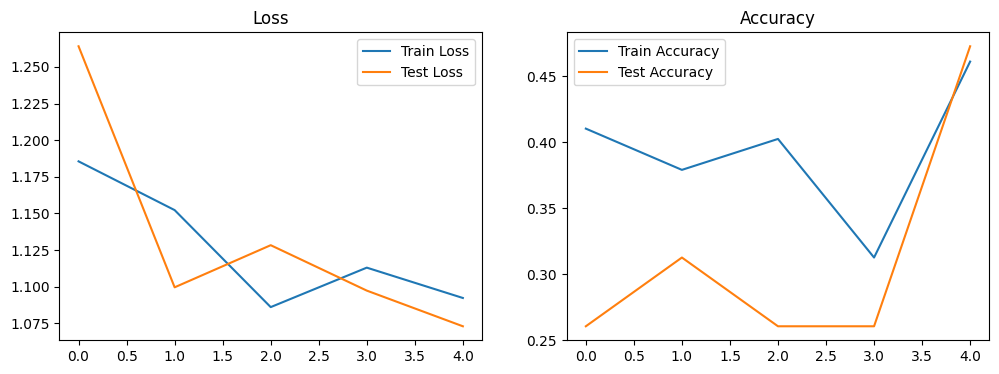

In [22]:
# 練習 Visualize
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
plt.plot(result_2["train_loss"], label = "Train Loss")
plt.plot(result_2["test_loss"], label = "Test Loss")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(result_2["train_acc"], label = "Train Accuracy")
plt.plot(result_2["test_acc"], label = "Test Accuracy")
plt.title("Accuracy")
plt.legend()